Setup code to download the dataset from kaggle and connect to google-drive.

In [0]:
# !pip install kaggle --upgrade
# !nvidia-smi
from google.colab import files
uploaded = files.upload()
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip -d data/
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('data')
path.ls()

[PosixPath('data/list_attr_celeba.csv'),
 PosixPath('data/list_bbox_celeba.csv'),
 PosixPath('data/list_eval_partition.csv'),
 PosixPath('data/list_landmarks_align_celeba.csv'),
 PosixPath('data/img_align_celeba')]

In [4]:
eval_df = pd.read_csv(path/'list_eval_partition.csv')
eval_df.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [5]:
landmarks_df = pd.read_csv(path/'list_landmarks_align_celeba.csv')
landmarks_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [0]:
df = pd.merge(eval_df, landmarks_df, on='image_id')

In [0]:
cols= list(landmarks_df.columns[1:])

In [0]:
fname = '000001.jpg'

# Labelling function

In [0]:
def get_func(fname):
    fname = Path(fname)
    val = df[df['image_id']==fname.name][cols].values
    return torch.from_numpy(val).view(val.shape[1]//2, 2).flip(0,1)

Sample Label

In [10]:
get_func(fname)

tensor([[154, 108],
        [152,  73],
        [142,  77],
        [113, 106],
        [109,  69]])

In [0]:
defaults.device = torch.device('cuda')

Loading data from disk with DataBlock api

In [0]:
bs = 1024 # set the bs according to gpu memory

In [0]:
src = (PointsItemList.from_df(df, path, 'image_id', 'img_align_celeba/img_align_celeba')
      .split_by_rand_pct(0.3)
      .label_from_func(get_func))        

In [0]:
tfms = get_transforms(max_lighting=0.1, max_warp=0.3, max_zoom=1.1, p_affine=0.8)

In [0]:
data= src.transform(tfms, tfm_y = True,size=(218,178)).databunch(bs=512).normalize(imagenet_stats)

Save data for later use

In [0]:
data.save('/content/gdrive/My Drive/Facedata');

Loading saved data to save time

In [0]:
data = load_data('/content/gdrive/My Drive/',file='Facedata-4096')

Have a look at the data.

In [0]:
gc.collect()

140

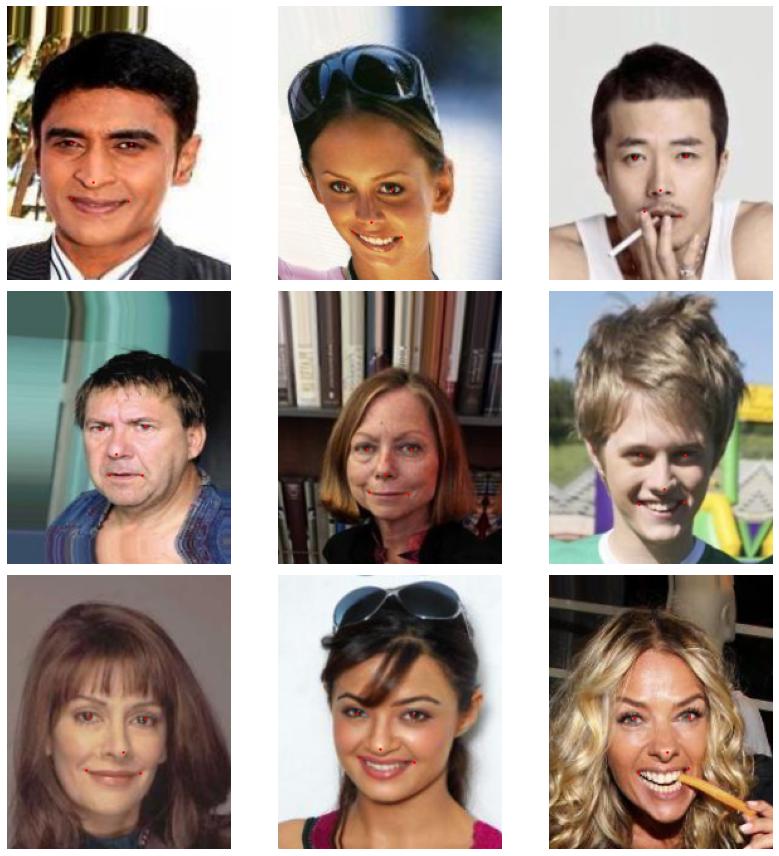

In [27]:
data.show_batch(3)

WingLoss for FaceLandmark detection. [Wing Loss for Robust Facial Landmark Localisation with Convolutional Neural Networks](https://arxiv.org/abs/1711.06753)

In [4]:
class WingLoss(nn.Module):
    def __init__(self, w=10, curvature=2):
        super().__init__()
        self.w, self.curvature = w, curvature
        self.C = w - w* math.log((1+w/curvature))
    
    def forward(self, y_hat,y):
        diff = y_hat - y.view(y.shape[0],-1)
        diff_abs = diff.abs()
        loss = diff_abs.clone()
        
        idx_smaller = diff_abs < self.w
        idx_bigger = diff_abs >= self.w
        
        loss[idx_smaller] = self.w * torch.log(1 + loss[idx_smaller].abs() / self.curvature)
        loss[idx_bigger] = loss[idx_bigger].abs() - self.C
        loss = loss.mean()
        
        return loss

In [23]:
#clear gpu memory. Required if pytorch has cached the gpu memory
learn = None
gc.collect()


1238

I have used mixed precision training here for getting through the training quickly.

In [0]:
learn = cnn_learner(data, models.resnet18,pretrained=True).to_fp16()

In [0]:
#setting the loss function
learn.loss_func = WingLoss()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


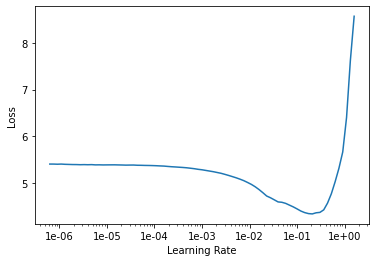

In [30]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [32]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.797177,0.597639,18:09
1,0.538367,0.511455,17:20
2,0.464039,0.444439,17:21
3,0.435672,0.303753,17:31
4,0.419948,0.344365,18:37
5,0.404051,0.436695,17:23
6,0.388858,0.405486,16:59
7,0.376557,0.358075,16:35
8,0.367078,0.308238,16:51
9,0.363099,0.308321,19:32


In [0]:
learn.save('celeba-stage-1')

In [0]:
learn.save('/content/gdrive/My Drive/celeba-stage-1-18')

In [0]:
learn.load('/content/gdrive/My Drive/celeba-stage-1')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


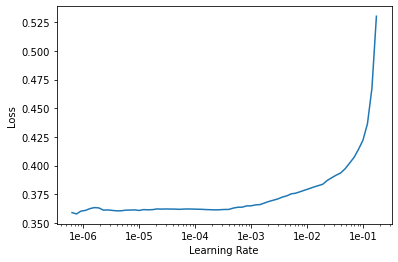

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10, slice(1e-5,2e-2/10))

epoch,train_loss,valid_loss,time
0,0.355884,0.248989,19:27
1,0.336754,0.354195,18:56
2,0.312437,0.175390,18:29
3,0.286749,0.325803,17:55
4,0.258631,0.142989,17:42
5,0.235769,0.201723,17:47
6,0.219507,0.148213,17:52
7,0.210710,0.176391,17:38
8,0.202251,0.137100,17:32
9,0.200060,0.136884,17:37


In [0]:
learn.save('celeba-stage-2')

In [0]:
learn.save('/content/gdrive/My Drive/celeba-stage-2-18')

In [0]:
learn.load('/content/gdrive/My Drive/celeba-stage-2')

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


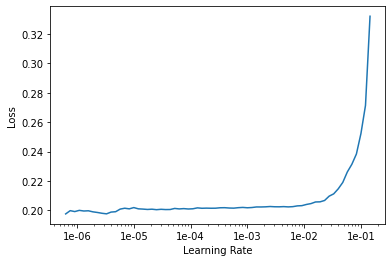

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(2, slice(1e-6))

epoch,train_loss,valid_loss,time
0,0.201229,0.131953,18:25
1,0.200813,0.131583,19:00


We can see the results look pretty good

In [0]:
learn.save('/content/gdrive/My Drive/celeba-stage-3-18')

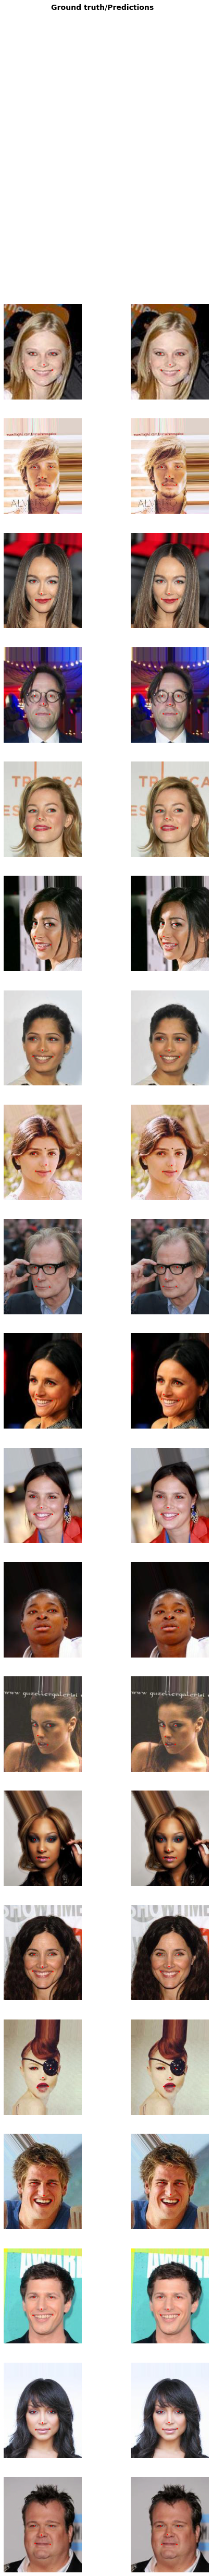

In [45]:
learn.show_results(rows=20)

Exporting the model for later use.

In [0]:
learn.export('/content/gdrive/My Drive/landmarks-resnet18.pkl')

# Testing the model on new data.

In [2]:
defaults.device = torch.device('cpu')

In [5]:
learner = load_learner('.',file='landmarks-resnet18.pkl').to_fp32()

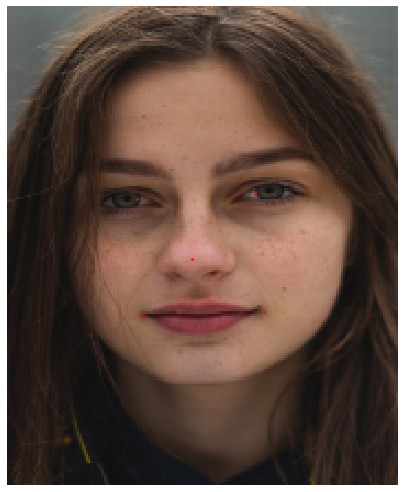

In [28]:
img1 = open_image('Test.jpeg')
img1.resize((3,218,178))
preds = learner.predict(img1)[0]
img1.show(y=preds,figsize=(7,10))

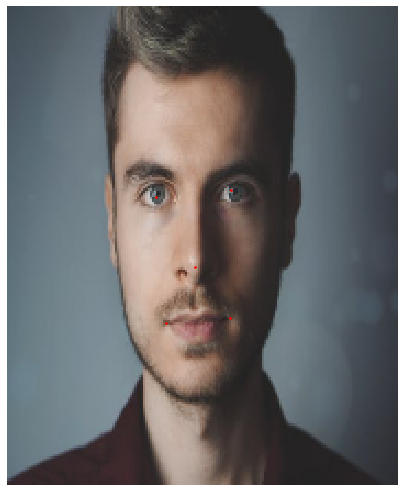

In [31]:
img1 = open_image('test.jpeg')
img1.resize((3,218,178))
preds = learner.predict(img1)[0]
img1.show(y=preds,figsize=(7,10))